# Preprocessing

### - Text correction and NLP preprocessing

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

## 0 Environment and Initiation

### Software and package version:

Ubuntu 18.04.1

Python 3.6.6

Jupyter 4.4.0

NLTK 3.4

gensim 3.4.0


### Directory structure:

```
data601/
├── data/
│   └──── file.tar.gz
│         ├── xaa
│         ├── xab
│         ├── xac
│         ├── xad
│         └── xae
└── scripts/
    └── preprocessing/
        ├── frequency_dictionary_en_82_765.txt
        └── preprocessing.ipynb

```

### Imports:

In [50]:
# imports
import os
import sys
import re
from io import StringIO
import glob
import timeit
import tarfile
import reprlib
from pprint import pprint
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

from symspellpy.symspellpy import SymSpell, Verbosity
#! wget https://raw.githubusercontent.com/wolfgarbe/SymSpell/master/SymSpell/frequency_dictionary_en_82_765.txt

import itertools

import nltk
from nltk.collocations import TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
# nltk.download('wordnet')

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS

import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
# commented for error:
# ParserError: Error tokenizing data. C error: Expected 6 fields in line 1763, saw 7

#path =r'../../data/preprocessing'
#files = glob.glob(path + "/*.txt")
#
#list_ = []
#
#for file_ in files:
#    df_ = pd.read_table(file_, index_col=None, header=None, encoding='utf8')
#    list_.append(df_)
#
#df = pd.concat(list_, axis = 0, ignore_index = True)

### Load dataset:

In [52]:
# only for interpretation

file = '../../data/preprocessing/Lyttelton_Times.txt'
#file = '../../data/preprocessing/Observer.txt'
df = pd.read_table(file, header=None, index_col=None, encoding='utf8')
df.columns = ['id', 'url', 'publisher', 'time', 'title', 'content']
print('Shape of dataframe:', df.shape)
df.sample(3)

Shape of dataframe: (28904, 6)


,id,url,publisher,time,title,content
28679,2387569,http://api.digitalnz.org/records/2387569/source,Lyttelton Times,1862-05-03T00:00:00.000Z,"MARRIED. (Lyttelton Times, 03 May 1862)","MARRIED.WATKINS—PAVHT—ApriI 29, at Akaroa, by ..."
17285,2177393,http://api.digitalnz.org/records/2177393/source,Lyttelton Times,1858-05-05T00:00:00.000Z,"Shipping News. (Lyttelton Times, 05 May 1858)","Shipping News.SAILED. "" May 1, schooner Mary T..."
8447,2034030,http://api.digitalnz.org/records/2034030/source,Lyttelton Times,1856-03-08T00:00:00.000Z,Page 3 Advertisements Column 1 (Lyttelton Time...,"rpHE Undersigned, having been appointed X agen..."


### Global variable configuration

In [53]:
# Configurations
# df columns name
COLUMNS_NAME = ['id', 'url', 'publisher', 'time', 'title', 'content']

# dataset is tar gzip file
FILE_GZ = '../../data/file.tar.gz'

# for fast debugging
CONF_SLICE = 10 #  Default: None, slice df if CONF_SLICE is not None

# configuration for Corpus class to control the text processing.
CONFIG = ['SPELL', 'STEM', 'LEMMA'] # select processing step, normally we do not need all of the steps.





## 1 Streaming Data

If we do not use parallelization in this script, we need to stream dataset to avoid memory overflow.

Data streaming is a important pattern: real data is typically too large to fit into RAM, and we don't need all of it in RAM at the same time anyway -- that's just wasteful. With streamed data, we can process arbitrarily large input, reading the data from a file on disk, SQL database, shared network disk, or even more exotic remote network protocols.

In this script we use a tar gzip file as dataset, which is the same with Lyttelteon_Times.txt but split into 5 parts and be compressed into one file.

In [54]:
def get_content(text, conf_slice=None):
    ''' Preprocess text from one file, returning the result as
        a list of unicode string.
    '''
    
    text_to_df = StringIO(text)
    df = pd.read_table(text_to_df, header=None, index_col=None)
    
    # slice for faster debug
    df = df[:conf_slice]
    print('get_content:: slice to {} length.'.format(conf_slice))
    
    df.columns = COLUMNS_NAME
    
    print('Shape of dataframe:', df.shape)
    #print(df.sample(3))
    
    content = df.content.values.tolist()
    print('Length of content list:', len(content))
    #print(content[0])
    
    return content

In [55]:
def iter_dataset(file_gz, conf_slice=None):
    ''' Yield content list of each file in compressed input file.
        The text are read from raw tar.gz file `file_gz` on disk (e.g. `./data/papers_past.tar.gz`)
    '''

    extracted = 0
    
    with tarfile.open(file_gz, 'r:gz') as tf:
        
        for file_number, file_info in enumerate(tf):
            
            if file_info.isfile():
                print('Read file:', file_number, file_info)
                text = gensim.utils.to_unicode(tf.extractfile(file_info).read(), 'latin1').strip()
                #print(len(text))
                
                yield get_content(text, conf_slice)
                extracted += 1

In [56]:
# for debug
# # `list(stream)` materializes the stream elements into a plain Python list
content_stream = iter_dataset(FILE_GZ, CONF_SLICE)
print(reprlib.repr(list(itertools.islice(content_stream, 2))))
#print(list(itertools.islice(content_stream, 1)))

Read file: 1 <TarInfo './files/xae' at 0x7f864d25c4f8>
get_content:: slice to 10 length.
Shape of dataframe: (10, 6)
Length of content list: 10
Read file: 2 <TarInfo './files/xac' at 0x7f864d25cb38>
get_content:: slice to 10 length.
Shape of dataframe: (10, 6)
Length of content list: 10
[['THE TORRENS ...r encumbered.', 'THE REVIEW O...nd total 1955', 'NELSON.[fkom... our "right."', 'TUESDAY, MAR... 24,1862. 941', 'COMMERCIAL.L...early i-5000.', 'LYTTELTON.AR...ey for Otago.', ...], ['BOOKBINDING....80¢ Â\x84 . ;', 'Markets.WELL... per 100 fts.', "Shipping New...awke's Bay. ,", 'The Lyttelto...elton itself.', "AHURIRI.' NA...h mentioning.", '#eto SHJbert...th, ISSS. . .', ...]]


Then wrap the generator inside an object's `__iter__` method, so we can iterate over the stream multiple times:

In [57]:
class CorpusGen(object):
    def __init__(self, fname, config, conf_slice):
        self.fname = fname
        self.config = config
        self.conf_slice = conf_slice

    def __iter__(self):
        for text in iter_dataset(self.fname, self.conf_slice):
            # pass for now, should be yiel
            pass

## 2 Spelling Correction

To increase the topic modeling quality, one of the most effective stratagy is improve the corpus/dataset quality. In this project we use OCR-ed texts which full of unreasonable error words. So we use `SymSpell` to improve the quality of dataset before tokenlization.

>The Symmetric Delete spelling correction algorithm reduces the complexity of edit candidate generation and dictionary lookup for a given Damerau-Levenshtein distance. It is six orders of magnitude faster (than the standard approach with deletes + transposes + replaces + inserts) and language independent.
>
>Opposite to other algorithms only deletes are required, no transposes + replaces + inserts. Transposes + replaces + inserts of the input term are transformed into deletes of the dictionary term. Replaces and inserts are expensive and language dependent: e.g. Chinese has 70,000 Unicode Han characters!
>
>The speed comes from the inexpensive delete-only edit candidate generation and the pre-calculation.
>An average 5 letter word has about 3 million possible spelling errors within a maximum edit distance of 3, but SymSpell needs to generate only 25 deletes to cover them all, both at pre-calculation and at lookup time. Magic!



We use the first text of the dataset to see the effect of spelling correction.

In [58]:
def correct_spelling(input_term, 
                     initial_capacity=83000, 
                     max_edit_distance_dictionary=2, 
                     max_edit_distance_lookup=2, 
                     prefix_length=7):
    ''' correct spelling of input text
    '''
    # create object
    #initial_capacity = 83000
    # maximum edit distance per dictionary precalculation
    #max_edit_distance_dictionary = 2
    #prefix_length = 7
    sym_spell = SymSpell(initial_capacity, max_edit_distance_dictionary,
                         prefix_length)
    # load dictionary
    dictionary_path = os.path.join(os.path.dirname("./"),
                                   "frequency_dictionary_en_82_765.txt")
    term_index = 0  # column of the term in the dictionary text file
    count_index = 1  # column of the term frequency in the dictionary text file
    if not sym_spell.load_dictionary(dictionary_path, term_index, count_index):
        print("Dictionary file not found")
        return -1
    
    # lookup suggestions for multi-word input strings (supports compound
    # splitting & merging)
    # max edit distance per lookup (per single word, not per whole input string)
    #max_edit_distance_lookup = 2
    suggestions = sym_spell.lookup_compound(input_term,
                                            max_edit_distance_lookup)
    # display suggestion term, edit distance, and term frequency
    #for suggestion in suggestions:
    #    print("{}, {}, {}".format(suggestion.term, suggestion.count,
    #                              suggestion.distance))

    return suggestions[0].term # risk: we suppose len(suggestions) == 1


# To Do:
# how to add words to dictionary?
# how to improve performance?

In [59]:
# for interpretation

input_term = df.content.values[0]
print('The Original text:\n', input_term)

t1 = timeit.default_timer()

output_term = correct_spelling(input_term)
print('\nThe corrected text:\n', output_term)

print('\nrun time:', timeit.default_timer() - t1, 's')

The Original text:
 fTIHE price of Advertisements in this Paper ■A- is, threepence a line for the first insertion, and a penny a line for every subsequent one. All communications to the Editor are requested to be addressed to the Office of the Lyttelton Times, Section 2, Norwich Quay, Lyttelton, where the Paper may be obtained. Advertisements must be left at this Office before Thursday evening, for insertion of the same week, and must be paid for at the time of insertion. NOTICE. ~ HIS EXCELLENCY SIR GEORGE GREY having declared that he will raise no objection to the erection of Canterbury into a separate Province, if the power be left in his hands, and if the settlers in Canterbury desire it, we, the undersigned, Magistrates of the district, think it right that opportunities should be given of ascertaining the wishes of the people on this important subject. For this purpose Public Meetings will be held at the Mitre Hotel, Lyttelton, on Wednesday, Aug. 13, at Two o'clock, p.m.; and at t

Then we add the function to class.

In [60]:
class CorpusGen(object):
    def __init__(self, fname, config, conf_slice):
        self.fname = fname
        self.config = config
        self.conf_slice = conf_slice

    def __iter__(self):
        for text in iter_dataset(self.fname, self.conf_slice):
            if 'SPELL' in self.config:
                # apply correct_spelling to all text list
                yield [correct_spelling(x) for x in text]

In [61]:
corpus_corrected = CorpusGen(FILE_GZ, CONFIG, CONF_SLICE)

# read two files to correct spelling, then print the result.
print(reprlib.repr(list(itertools.islice(corpus_corrected, 2))))
#print(list(itertools.islice(corrected_corpus, 2)))

Read file: 1 <TarInfo './files/xae' at 0x7f862821e688>
get_content:: slice to 10 length.
Shape of dataframe: (10, 6)
Length of content list: 10
Read file: 2 <TarInfo './files/xac' at 0x7f862821e9a8>
get_content:: slice to 10 length.
Shape of dataframe: (10, 6)
Length of content list: 10
[['\ufeffthe to...or encumbered', '\ufeffthe re...d total of of', 'nelson from ... of our right', 'tuesday marc...of of of a of', 'commercial l...early i of of', 'let elton ar...ydney for ago', ...], ['bookbinding ...of of a a a a', 'markets well... per a of its', 'shipping new...n hawkers bay', '\ufeffthe le... elton itself', 'hurt i nativ...th mentioning', 'to shjbertfs...jan both isis', ...]]


In [62]:
# # package correct_spelling() function for df.apply()
# def app_correct_spelling(input_term, 
#                          initial_capacity=83000, 
#                          max_edit_distance_dictionary=2, 
#                          max_edit_distance_lookup=2, 
#                          prefix_length=7):
#     '''an encapsulation of correct_spelling() function changing the input_term.
#     '''
#     return correct_spelling(input_term.content, 
#                             initial_capacity, 
#                             max_edit_distance_dictionary, 
#                             max_edit_distance_lookup, 
#                             prefix_length)

In [63]:
# # verify apply
# t1 = timeit.default_timer()
# 
# df['correction'] = df.apply(app_correct_spelling, axis=1)
# df.sample(3)
# 
# print('\nrun time:', timeit.default_timer() - t1, 's')

## 3 Text Processing

### 3.1 Collocations and Named Entity Recognition

Collocation is a "sequence of words or terms that co-occur more often than would be expected by chance."

Named entity recognition (NER) is the task of locating chunks of text that refer to people, locations, organizations etc.

Detecting collocations and named entities often has a significant business value: "General Electric" stays a single entity (token), rather than two words "general" and "electric". Same with "Marathon Petroleum", "George Bush" etc -- a topic model doesn't confuse its topics via words coming from unrelated entities, such as "Korea" and "Carolina" via "North".

In [70]:
def best_ngrams(words, top_n=1000, min_freq=100):
    ''' Extract `top_n` most salient collocations (bigrams and trigrams),
        from a stream of words. Ignore collocations with frequency
        lower than `min_freq`.
    
        This function uses NLTK for the collocation detection itself -- not very scalable!
    
        Return the detected ngrams as compiled regular expressions, for their faster
        detection later on.
    '''

    tcf = TrigramCollocationFinder.from_words(words)
    tcf.apply_freq_filter(min_freq)
    trigrams = [' '.join(w) for w in tcf.nbest(TrigramAssocMeasures.chi_sq, top_n)]
    print("{} trigrams found: {}...".format(len(trigrams), trigrams[:20]))

    bcf = tcf.bigram_finder()
    bcf.apply_freq_filter(min_freq)
    bigrams = [' '.join(w) for w in bcf.nbest(BigramAssocMeasures.pmi, top_n)]
    print("{} bigrams found: {}...".format(len(bigrams), bigrams[:20]))

    pat_gram2 = re.compile('(%s)' % '|'.join(bigrams), re.UNICODE)
    pat_gram3 = re.compile('(%s)' % '|'.join(trigrams), re.UNICODE)

    return pat_gram2, pat_gram3

In [71]:
def split_words(text, stopwords=STOPWORDS):
    ''' Break text into a list of single words. Ignore any token that falls into
        the `stopwords` set.
    '''
    return [word
            for word in gensim.utils.tokenize(str(text), lower=True)
            if word not in stopwords and len(word) > 3]

We use above function to build bigrams and trigrams at first.

In [72]:
# generator of documents of all words
documents = (split_words(''.join(str(x) for x in text)) for text in iter_dataset(FILE_GZ))
# generator: concatenate (chain) all words into a single sequence, lazily
words = itertools.chain.from_iterable(documents)

bigrams, trigrams = best_ngrams(words)

Read file: 1 <TarInfo './files/xae' at 0x7f862821e8e0>
get_content:: slice to None length.
Shape of dataframe: (910, 6)
Length of content list: 910
Read file: 2 <TarInfo './files/xac' at 0x7f862821ec00>
get_content:: slice to None length.
Shape of dataframe: (6996, 6)
Length of content list: 6996
Read file: 3 <TarInfo './files/xaa' at 0x7f862821e818>
get_content:: slice to None length.
Shape of dataframe: (6999, 6)
Length of content list: 6999
Read file: 4 <TarInfo './files/xab' at 0x7f862821ecc8>
get_content:: slice to None length.
Shape of dataframe: (7000, 6)
Length of content list: 7000
Read file: 5 <TarInfo './files/xad' at 0x7f862821ea70>
get_content:: slice to None length.
Shape of dataframe: (6999, 6)
Length of content list: 6999
1000 trigrams found: ['specifically infallibly rectifying', 'infallibly rectifying irregularities', 'richmond chandler salford', 'chandler salford barrett', 'pervades connects marvellous', 'salford barrett exall', 'pears plums cherries', 'nervous perva

### 3.2 Corpus generator

After we get bi-grams and tri-grams, we wrap up general NLP text processes into one class and instance it to get a corpus generator which could be used for topic modeling.

In [73]:
def tokenize(text, bigrams, trigrams):
    ''' Break text (string) into a list of Unicode tokens.
        The resulting tokens can be longer phrases (collocations) too,
        e.g. `new_york`, `real_estate` etc.
    '''
    
    text = u' '.join(split_words(text))
    text = re.sub(trigrams, lambda match: match.group(0).replace(u' ', u'_'), text)
    text = re.sub(bigrams, lambda match: match.group(0).replace(u' ', u'_'), text)
    
    return text.split()

In [74]:
# corpus generator
class CorpusGen(object):
    ''' corpus generator
        input: tgz file path, config list
        output: iterable
    '''
    
    def __init__(self, fname, config, conf_slice):
        self.fname = fname
        self.config = config
        self.conf_slice = conf_slice

    def __iter__(self):
        ''' generate data
        '''
        
        for text_list in iter_dataset(self.fname, self.conf_slice):
            
            # 1. Spelling Correction
            if 'SPELL' in self.config:
                # apply correct_spelling to all text list
                text_list = [correct_spelling(x) for x in text_list]
                
            # 2. Tokenization
            corpus = [tokenize(x, bigrams, trigrams) for x in text_list]
            
            # 3. Stemming
            if 'STEM' in self.config:
                stemmer = PorterStemmer()
                corpus = [[stemmer.stem(y) for y in x] for x in corpus]
            
            # 4. Lemmatization
            if 'LEMMA' in self.config:
                lemma = WordNetLemmatizer()
                corpus = [[lemma.lemmatize(y) for y in x] for x in corpus]
            
            yield corpus

In [75]:
t1 = timeit.default_timer()

# select steps
CONFIG = ['SPELL', 'STEM', 'LEMMA']

# Slice dataset
CONF_SLICE = 10

# get full corpus
corpus_iter = CorpusGen(FILE_GZ, CONFIG, CONF_SLICE)

corpora_list = []
for corpus in corpus_iter:
    corpora_list += corpus

print(corpora_list)

#print(reprlib.repr(list(itertools.islice(corpus_iter, 2))))
#print(list(itertools.islice(corpus, 2)))

print('\nrun time:', (timeit.default_timer() - t1)/60, 'mins')

Read file: 1 <TarInfo './files/xae' at 0x7f862821eb38>
get_content:: slice to 10 length.
Shape of dataframe: (10, 6)
Length of content list: 10
Read file: 2 <TarInfo './files/xac' at 0x7f862821ec00>
get_content:: slice to 10 length.
Shape of dataframe: (10, 6)
Length of content list: 10
Read file: 3 <TarInfo './files/xaa' at 0x7f864a90a368>
get_content:: slice to 10 length.
Shape of dataframe: (10, 6)
Length of content list: 10
Read file: 4 <TarInfo './files/xab' at 0x7f864a90a750>
get_content:: slice to 10 length.
Shape of dataframe: (10, 6)
Length of content list: 10
Read file: 5 <TarInfo './files/xad' at 0x7f864a90ac00>
get_content:: slice to 10 length.
Shape of dataframe: (10, 6)
Length of content list: 10
[['torren', 'real', 'properti', 'melbourn', 'argu', 'charact', 'oper', 'torren', 'properti', 'forc', 'south', 'australia', 'best', 'studi', 'report', 'commission', 'appoint', 'investig', 'work', 'indic', 'amend', 'suscept', 'lute', 'present', 'chief', 'justic', 'south', 'australi

Finally we get the corpus for topic modeling. We will validate the corpus in the following part.

## 4 Validating

We directly using the corpus build the input of topic modeling, and training a model using MALLET, then check the coherence value at the end.

In [76]:
# Create Dictionary
id2word = corpora.Dictionary(corpora_list)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in corpora_list]
# print(corpus[:1]) # unreadable

# Readable format of corpus
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ablest', 1),
  ('absolut', 1),
  ('accumul', 1),
  ('acquir', 1),
  ('acquisit', 1),
  ('acr', 1),
  ('adelaid', 1),
  ('adequ', 1),
  ('administr', 1),
  ('aero', 2),
  ('affect', 4),
  ('alien', 1),
  ('alleg', 2),
  ('allud', 1),
  ('amaz', 1),
  ('amend', 3),
  ('amer', 1),
  ('anticip', 1),
  ('appear', 4),
  ('appendix', 1),
  ('appli', 2),
  ('appoint', 3),
  ('approach', 1),
  ('argu', 1),
  ('aspir', 1),
  ('assur', 1),
  ('attain', 1),
  ('attent', 1),
  ('australia', 7),
  ('australian', 1),
  ('base', 1),
  ('benefici', 1),
  ('benefit', 1),
  ('best', 1),
  ('bore', 1),
  ('breed', 1),
  ('breviti', 1),
  ('broker', 1),
  ('brought', 1),
  ('cairn', 1),
  ('capabl', 2),
  ('cation', 1),
  ('cement', 1),
  ('cent', 1),
  ('centuri', 2),
  ('chancellor', 1),
  ('chang', 1),
  ('charact', 1),
  ('charg', 2),
  ('cheap', 3),
  ('chief', 2),
  ('china', 1),
  ('claim', 2),
  ('class', 1),
  ('clear', 1),
  ('clip', 1),
  ('coloni', 2),
  ('comedi', 1),
  ('commentari', 1),


In [77]:
mallet_path = '/usr/local/share/Mallet/bin/mallet' # the path is vary in a different server/computer.
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus, 
                                             num_topics=35, 
                                             id2word=id2word,
                                             workers=6,
                                             optimize_interval=10,
                                             iterations=1000)

In [78]:
# Show Topics
pprint(ldamallet.show_topics(num_topics=35, num_words=10, formatted=False))

[(0,
  [('prison', 0.04176334106728538),
   ('garrett', 0.027842227378190254),
   ('pump', 0.018561484918793503),
   ('gold', 0.016241299303944315),
   ('water', 0.016241299303944315),
   ('bank', 0.016241299303944315),
   ('compani', 0.013921113689095127),
   ('lord', 0.01160092807424594),
   ('home', 0.01160092807424594),
   ('ticket', 0.01160092807424594)]),
 (1,
  [('immigr', 0.04195804195804196),
   ('nelson', 0.03496503496503497),
   ('hall', 0.027972027972027972),
   ('provinci', 0.02097902097902098),
   ('grant', 0.02097902097902098),
   ('arriv', 0.02097902097902098),
   ('privileg', 0.013986013986013986),
   ('ram', 0.013986013986013986),
   ('settl', 0.013986013986013986),
   ('promis', 0.013986013986013986)]),
 (2,
  [('guard', nan),
   ('glenda', nan),
   ('hundr', nan),
   ('hoff', nan),
   ('hoard', nan),
   ('hast', nan),
   ('imposs', nan),
   ('gordon', nan),
   ('frustrat', nan),
   ('gallant', nan)]),
 (3,
  [('england', 0.04807692307692308),
   ('reform', 0.0480769

/usr/local/lib/python3.5/dist-packages/gensim/models/wrappers/ldamallet.py:442: RuntimeWarning: invalid value encountered in true_divide
  topic = topic / topic.sum()  # normalize to probability dist


In [79]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=corpora_list, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

/usr/local/lib/python3.5/dist-packages/gensim/models/wrappers/ldamallet.py:373: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]



Coherence Score:  0.49014129966800285


In [80]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                 corpus=corpus, 
                                                 num_topics=num_topics, 
                                                 id2word=id2word,
                                                 workers=6,
                                                 optimize_interval=10,
                                                 iterations=1000)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [81]:
# long time to run.
limit=70; start=20; step=5;
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=corpora_list, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

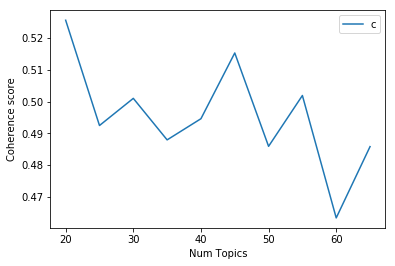

In [82]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [83]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 20  has Coherence Value of 0.5256
Num Topics = 25  has Coherence Value of 0.4925
Num Topics = 30  has Coherence Value of 0.501
Num Topics = 35  has Coherence Value of 0.4879
Num Topics = 40  has Coherence Value of 0.4946
Num Topics = 45  has Coherence Value of 0.5153
Num Topics = 50  has Coherence Value of 0.4859
Num Topics = 55  has Coherence Value of 0.5019
Num Topics = 60  has Coherence Value of 0.4634
Num Topics = 65  has Coherence Value of 0.4858


## 5 Futur Work

1. For time limit, we did not use full dataset to validate, next step we will use full dataset to check the result and try to find performance bottleneck.
1. Compare different processing pipe line (e.g. with or without spelling correction/stemming/lemmatization), to find out the most efficient processing pipe line.
1. The `SymSpell` package was not as fast as it claimed, need improve the performance.
1. Try to improve the text processing pipe line, for example, using TF-IDF to filter low frequency words.
1. The structure of code (class, function, etc.) should improve to be more efficient, elegant and readable.
1. We use word bag model here, there are papers prove word embeddings could be used to topic modeling, we may try to perform a Word2Vec text processing pipe line.

## 6 Summary

In this notebook, we use below step to process a compressed tar gzip file which contains the Lyttelton Times dataset.

1. streaming data, to accept big data.
1. spelling correction, to improve corpus quality
1. tokenization
1. n-grams
1. Stemming
1. Lemmatization

Then we use MALLET to validate the result of above text processing pipe line.

Finally we list futur work.

## Reference

https://towardsdatascience.com/symspell-vs-bk-tree-100x-faster-fuzzy-string-search-spell-checking-c4f10d80a078

https://medium.com/@ageitgey/natural-language-processing-is-fun-9a0bff37854e

https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

https://github.com/TiesdeKok/Python_NLP_Tutorial/blob/master/NLP_Notebook.ipynb

https://github.com/piskvorky/topic_modeling_tutorial

https://www.datacamp.com/community/tutorials/lda2vec-topic-model

https://towardsdatascience.com/combing-lda-and-word-embeddings-for-topic-modeling-fe4a1315a5b4